# Topic: **Traffic Density Detection**
### Course: **Artificial Intelligence IT159IU**
### Framework - Library: **OpenCV**, **scikit-image**, **PyTorch**, **matplotlib**

#### **Group name**: N/A
<ol type="1">
  <li>Tran The Phong - ITCSIU21215</li>
  <li>Nguyen Binh Phuong Huy - ITCSIU21189</li>
  <li>Do Gia Thuy - ITCSIU21237</li>
</ol>

## Install essential package
Kaggle Package
```python
! pip install kaggle
```

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download "rahat52/traffic-density-singapore"

Dataset URL: https://www.kaggle.com/datasets/rahat52/traffic-density-singapore
License(s): GNU Free Documentation License 1.3
 95% 210M/222M [00:01<00:00, 140MB/s]
100% 222M/222M [00:01<00:00, 139MB/s]


In [ ]:
!unzip traffic-density-singapore.zip

Archive:  traffic-density-singapore.zip
  inflating: Final Dataset/testing/Empty/00a2d16e-742e-469f-a23a-631ad49ec790.jpg  
  inflating: Final Dataset/testing/Empty/01d0f221-a94d-44ce-ba07-462f2f46f62c.jpg  
  inflating: Final Dataset/testing/Empty/02bbbe52-297c-4eed-aac2-de40ad6bd0b8.jpg  
  inflating: Final Dataset/testing/Empty/0a175e12-bade-49c4-ad00-c07329ce5fd4.jpg  
  inflating: Final Dataset/testing/Empty/0a37454f-40c2-4302-9e8b-23af7b95875b.jpg  
  inflating: Final Dataset/testing/Empty/0a7b874b-20dd-4ab2-b2ed-89645e4c20bc.jpg  
  inflating: Final Dataset/testing/Empty/0a86cfa7-7b99-4ce7-8da8-42c51d2eafff.jpg  
  inflating: Final Dataset/testing/Empty/0aad5c2c-a166-416a-9d6d-3e5da232a5ae.jpg  
  inflating: Final Dataset/testing/Empty/0acd3ef9-fa98-4e37-aca9-58e4848e36fd.jpg  
  inflating: Final Dataset/testing/Empty/0b6dc85e-a9ba-4d74-8682-d4dd58587bef.jpg  
  inflating: Final Dataset/testing/Empty/0ba3c8b2-04e2-401e-bb05-9f70e1740168.jpg  
  inflating: Final Dataset/testing/E

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from google.colab import drive
# drive.mount('/content/drive')

# Dataset paths
train_dir = "/content/Final Dataset/training"
val_dir = "/content/Final Dataset/validation"
test_dir = "/content/Final Dataset/testing"

# Image preprocessing and augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_ds = ImageFolder(root=train_dir, transform=None)
val_ds = ImageFolder(root=val_dir, transform=val_transform)
test_ds = ImageFolder(root=test_dir, transform=val_transform)

# DataLoaders
batch_size = 32
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Classes
classes = train_ds.classes
print("Classes:", classes)


Classes: ['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TrafficDensityCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrafficDensityCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Optional batch normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Optional batch normalization
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Optional batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BN -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)                       # Flatten the feature maps
        x = F.relu(self.fc1(x))                         # Fully connected layer 1 -> ReLU
        x = self.fc2(x)                                 # Output layer
        return x

# Initialize model with number of classes
num_classes = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficDensityCNN(num_classes).to(device)


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from torchsummary import summary

input_shape = (3,128, 128)
inputs = Input((input_shape))

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Linear-10                  [-1, 256]       8,388,864
           Linear-11                    [-1, 5]           1,285
Total params: 8,483,845
Trainable params: 8,483,845
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

In [ ]:
pip install torchviz

In [ ]:
from torchviz import make_dot

# Create a sample input tensor (e.g., for an image of size (3, 128, 128))
sample_input = torch.randn(1, 3, 128, 128).to(device)

# Perform a forward pass through the model
output = model(sample_input)

# Generate and save the visualization of the computation graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_graph", format="png")  # Saves the graph as a PNG image

'model_graph.png'

In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        patience: Số epoch chờ trước khi stop nếu không có cải thiện
        delta: Mức tăng tối thiểu để coi là có cải thiện
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_acc = 0.0

    def __call__(self, val_acc, model, path):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model, path)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, path):
        if self.verbose:
            print(f"Validation accuracy increased ({self.best_val_acc:.4f} --> {val_acc:.4f}). Saving model...")
        torch.save(model.state_dict(), path)
        self.best_val_acc = val_acc

early_stopper = EarlyStopping(patience=50, verbose=True)

In [ ]:
# Part 3: Training and Validation with Data Augmentation for Imbalanced Dataset and Saving the Best Model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

# Assume train_transform is defined from the first part
# and train_ds is loaded without transforms

# Compute class counts in the training dataset
train_targets = train_ds.targets  # List of class indices
class_counts = Counter(train_targets)

# Compute the maximum class count
max_count = max(class_counts.values())

# Define a custom Dataset class to handle oversampling with data augmentation
class AugmentedDataset(Dataset):
    def __init__(self, dataset, max_count, transform):
        self.dataset = dataset  # Original dataset without transforms
        self.max_count = max_count  # Desired number of samples per class
        self.transform = transform  # Transformations to apply
        self.class_indices = self._get_class_indices()
        self.indices = self._generate_indices()

    def _get_class_indices(self):
        class_indices = {}
        for idx, label in enumerate(self.dataset.targets):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        return class_indices

    def _generate_indices(self):
        indices = []
        for class_id, idx_list in self.class_indices.items():
            num_samples = len(idx_list)
            num_to_add = self.max_count - num_samples
            # Add original indices
            indices.extend(idx_list)
            # Oversample minority classes
            if num_to_add > 0:
                extra_indices = np.random.choice(idx_list, num_to_add, replace=True)
                indices.extend(extra_indices)
        np.random.shuffle(indices)
        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img, label = self.dataset[original_idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Create the augmented training dataset
augmented_train_ds = AugmentedDataset(train_ds, max_count, train_transform)

# Create DataLoader for the augmented training dataset
batch_size = 64
train_dl = DataLoader(augmented_train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Loss function and optimizer
# Ensure device and model are already defined from Part 2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Scheduler giảm learning rate nếu val_acc không tăng sau vài epoch
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


# Variables to track the best model
best_val_accuracy = 0.0
best_model_path = 'best_traffic_density_cnn.pth'

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        # Forward pass
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate loss and correct predictions
        train_loss += loss.item() * imgs.size(0)  # Multiply by batch size
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = train_correct / len(augmented_train_ds)
    avg_train_loss = train_loss / len(augmented_train_ds)
    train_acc_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            # Accumulate loss and correct predictions
            val_loss += loss.item() * imgs.size(0)  # Multiply by batch size
            val_correct += (outputs.argmax(1) == labels).sum().item()
    # Calculate average loss and accuracy
    # avg_train_loss = train_loss / len(augmented_train_ds)
    # avg_val_loss = val_loss / len(val_ds)
    # train_accuracy = train_correct / len(augmented_train_ds)
    # val_accuracy = val_correct / len(val_ds)
    val_accuracy = val_correct / len(val_ds)
    avg_val_loss = val_loss / len(val_ds)
    val_acc_history.append(val_accuracy)
    val_loss_history.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Cập nhật scheduler
    scheduler.step(val_accuracy)

    # Kiểm tra Early Stopping
    early_stopper(val_accuracy, model, best_model_path)
    if early_stopper.early_stop:
        print("Dừng sớm do không có cải thiện trên tập validation.")
        break

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with Val Acc: {best_val_accuracy:.4f}")

# Load the best model after training
model.load_state_dict(torch.load(best_model_path))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000
Train Loss: 2.8827, Train Acc: 0.4003
Val Loss: 1.0610, Val Acc: 0.5353
Validation accuracy increased (0.0000 --> 0.5353). Saving model...
Best model saved with Val Acc: 0.5353
Epoch 2/1000
Train Loss: 1.1444, Train Acc: 0.5300
Val Loss: 1.1289, Val Acc: 0.5706
Validation accuracy increased (0.5353 --> 0.5706). Saving model...
Best model saved with Val Acc: 0.5706
Epoch 3/1000
Train Loss: 1.0909, Train Acc: 0.5580
Val Loss: 0.9407, Val Acc: 0.6265
Validation accuracy increased (0.5706 --> 0.6265). Saving model...
Best model saved with Val Acc: 0.6265
Epoch 4/1000
Train Loss: 0.9836, Train Acc: 0.5951
Val Loss: 0.8863, Val Acc: 0.5882
EarlyStopping counter: 1 out of 50
Epoch 5/1000
Train Loss: 0.9275, Train Acc: 0.6272
Val Loss: 0.8015, Val Acc: 0.7176
Validation accuracy increased (0.6265 --> 0.7176). Saving model...
Best model saved with Val Acc: 0.7176
Epoch 6/1000
Train Loss: 0.8804, Train Acc: 0.6358
Val Loss: 0.7031, Val Acc: 0.7176
Validation accuracy increased (0.71

<ipython-input-11-f7fa28a18af3>:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

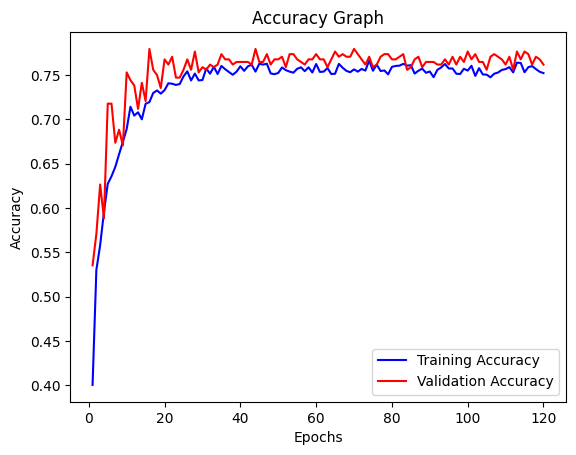

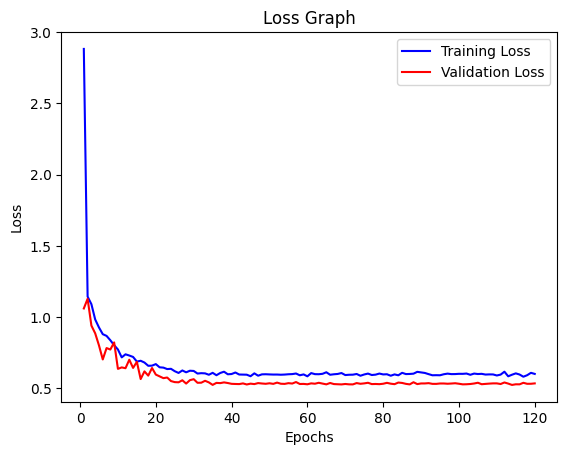

In [ ]:
# Part 4: Plot the result

import matplotlib.pyplot as plt

# Plot Accuracy and Loss Graphs
epochs_range = range(1, len(train_acc_history) + 1)

# Accuracy Graph
plt.plot(epochs_range, train_acc_history, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Graph
plt.plot(epochs_range, train_loss_history, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Part 5: Testing the Best Model

# Ensure the model is on the correct device and in evaluation mode
model.to(device)
model.eval()

test_correct = 0
with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8125


In [ ]:
# torch.save(model.state_dict(), "traffic_density_cnn.pth")

# Reload the model
model = TrafficDensityCNN(num_classes)
model.load_state_dict(torch.load("/content/best_traffic_density_cnn.pth"))
model.to(device)
model.eval()

<ipython-input-15-61c607297292>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_traffic_density_cnn.pth"))


TrafficDensityCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

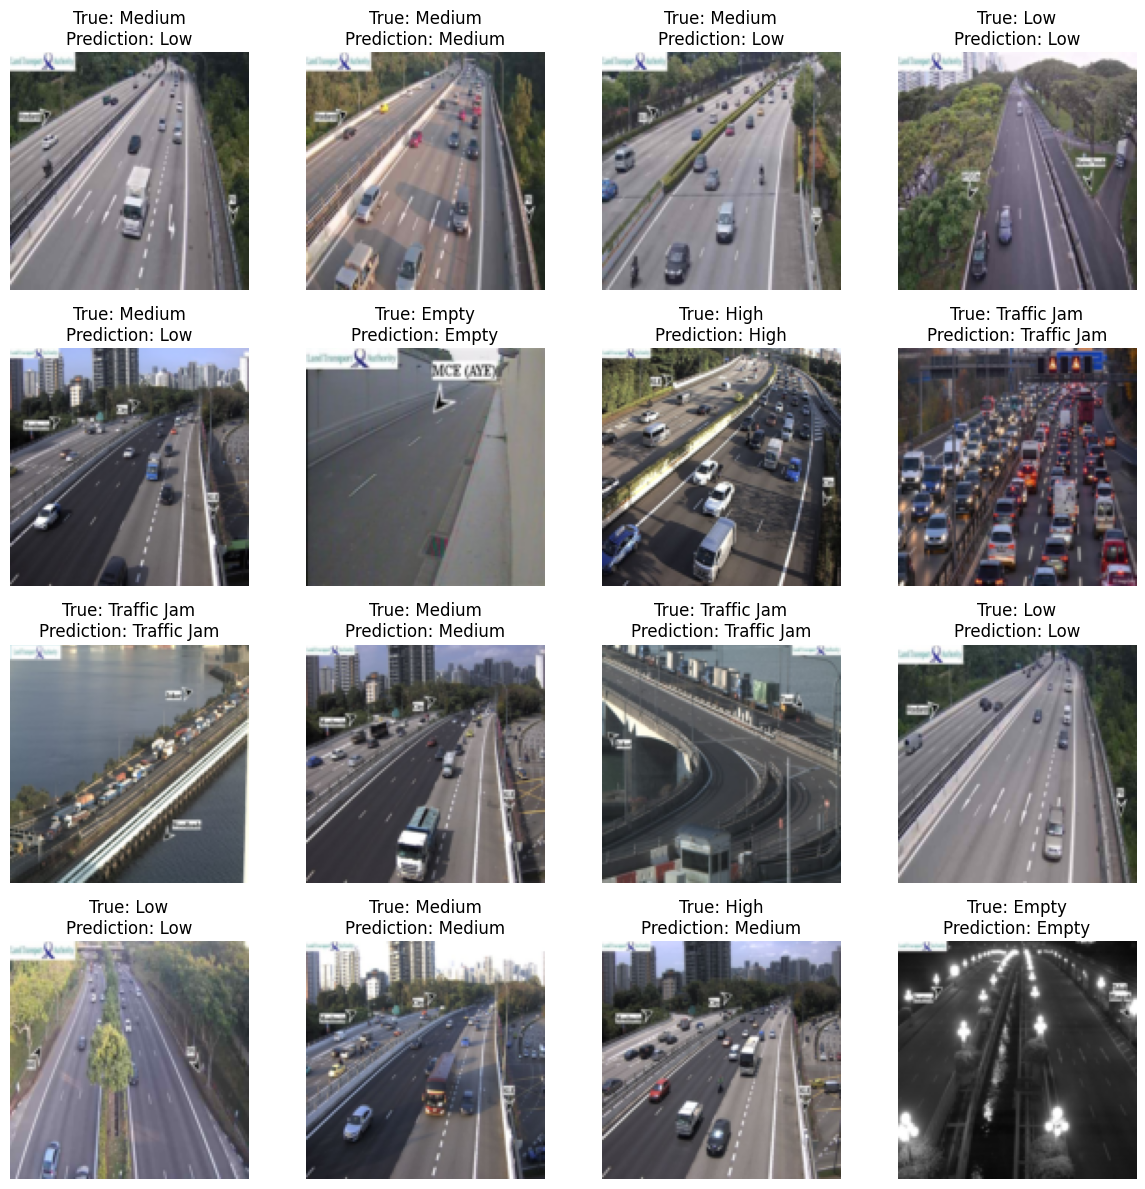

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Fetch a random batch of images and labels
imgs, labels = next(iter(test_dl))
imgs = imgs.to(device)

# Get model predictions
outputs = model(imgs)
preds = outputs.argmax(1)

# Plot images with predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

# Ensure we only iterate over the available images in the batch
num_images = min(len(imgs), 16)  # Use the smaller of batch size or 16
for i in range(num_images):
    # Denormalize the image for visualization
    img = imgs[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
    label = classes[labels[i].item()]
    pred = classes[preds[i].item()]
    axes[i].imshow(img)
    axes[i].set_title(f"True: {label}\nPrediction: {pred}")
    axes[i].axis("off")

# Turn off unused subplots if the batch has fewer than 16 images
for i in range(num_images, 16):
    axes[i].axis("off")

plt.tight_layout()
plt.show()